In [1]:
pip install qiskit==0.19.2

     |████████████████████████████████| 6.7MB 4.0MB/s 
     |████████████████████████████████| 23.4MB 1.7MB/s 
     |████████████████████████████████| 163kB 55.5MB/s 
     |████████████████████████████████| 174kB 51.8MB/s 
     |████████████████████████████████| 1.9MB 48.2MB/s 
     |████████████████████████████████| 51kB 4.6MB/s 
     |████████████████████████████████| 1.3MB 50.7MB/s 
     |████████████████████████████████| 5.9MB 52.6MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 194kB 32.2MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 29.5MB 165kB/s 
     |████████████████████████████████| 614kB 40.3MB/s 
     |████████████████████████████████| 2.6MB 32.7MB/s 
  Created wheel for qiskit: filename=qiskit-0.19.2-cp36-none-any.whl size=2894 sha256=aa764198f71c9fe3d4510ff956b400a3de71b5323f7d46752edf978428fb18c8
  Stored in directory: /root/.cache/pip/wheels/d8/29/6e/e065f721b42fe704

In [ ]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from tqdm.notebook import tqdm  #　jupyter用
# from tqdm import tqdm  # jupyter以外用

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua import QuantumInstance
from qiskit.ml.datasets import ad_hoc_data, breast_cancer
from qiskit.aqua import aqua_globals
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.algorithms import SklearnSVM
from qiskit.aqua.algorithms import QSVM
from qiskit.circuit.library import ZZFeatureMap

In [ ]:
# 訓練・テストデータの設定
feature_dim = 2  # 特徴量の数
training_dataset_size = 20
testing_dataset_size = 10

# 予測データの設定
size = 50  # 50x50のメッシュを分類によって色分けし、擬似的に境界面を可視化する
mesh_list = [[2*i/size-1, 2*j/size-1] for i in range(size+1) for j in range(size+1)]

# 量子コンピュータのパラメータ設定
shots = 1024
seed = 10598

In [ ]:
def eval_model(pred_label, print_mode=True):
    test_label = ["A"]*testing_dataset_size + ["B"]*testing_dataset_size

    accuracy = sum([x == y for x, y in zip(pred_label, test_label)])/len(test_label)
    precision = sum([x == y for x, y in zip(pred_label, test_label) if x == "A"])/sum([x == "A" for x in pred_label])
    recall = sum([x == y for x, y in zip(pred_label, test_label) if y == "A"])/sum([y == "A" for y in test_label])
    specificity = sum([x == y for x, y in zip(pred_label, test_label) if y == "B"])/sum([y == "B" for y in test_label])
    f1 = 2*recall*precision/(recall + precision)

    eval_dict = {"accuracy": accuracy, "precision": precision, "recall": recall, "specificity": specificity, "F1-measure":f1}
    if print_mode:
        print("result: ", pred_label)
        print("truth : ", test_label)
        print(eval_dict)
    else:
        return eval_dict

In [ ]:
def heatmap(pred_list, size=50):
    mat = np.flipud(pred_list.reshape(size+1, size+1, order='F'))
    centers = [-1, 1, -1, 1]
    dx, = np.diff(centers[:2])/(size)
    dy, = -np.diff(centers[2:])/(size)
    extent = [centers[0]-dx/3, centers[1]+dx/3, centers[2]+dy/3, centers[3]-dy/3]
    cmap = mpl.colors.ListedColormap(['orange', 'cyan'])
    # ヒートマップ表示
    plt.imshow(mat, interpolation='nearest', vmin=0, vmax=1, cmap=cmap, extent=extent)


def scatter_data(train_for_pred, test_for_pred, train_result, test_result,
                 yshift=-0.155, print_index=False):
    dataset_dict = {"train": train_for_pred, "test": test_for_pred}
    result_dict = {"train":train_result, "test":test_result}
    marker_dict = {"train": "o", "test": "s"}

    for data_type in ["train", "test"]:
        data_num_half = int(len(dataset_dict[data_type])/2) # ラベルA/Bのデータ数が1:1と仮定とする
        for label in ["A", "B"]:  
            if label == "A":
                (plot_data, color) = dataset_dict[data_type][:data_num_half], "red"
            elif label == "B":
                (plot_data, color) = dataset_dict[data_type][data_num_half:], "blue"
            plt.plot(plot_data[:,0], plot_data[:,1], marker_dict[data_type], color=color, markersize=10)

        # 誤分類を×マークでプロット
        for i, pred_label in enumerate(result_dict[data_type]):
            if (i < data_num_half and pred_label != 0)\
              or (i >= data_num_half and pred_label != 1): 
                if print_index:
                    plt.text(dataset_dict[data_type][i][0], dataset_dict[data_type][i][1], str(i), 
                            color="white", size=15, fontweight='bold')
                # ↓ x方向は自動、y方向は手動にてプロットの位置の微調整が現状ベスト
                plt.text(dataset_dict[data_type][i][0], dataset_dict[data_type][i][1] + yshift, "×", 
                         horizontalalignment='center', color="white", size=15, fontweight='bold')
        plt.axis('off')
        plt.title("Classification Boundary", size=15)

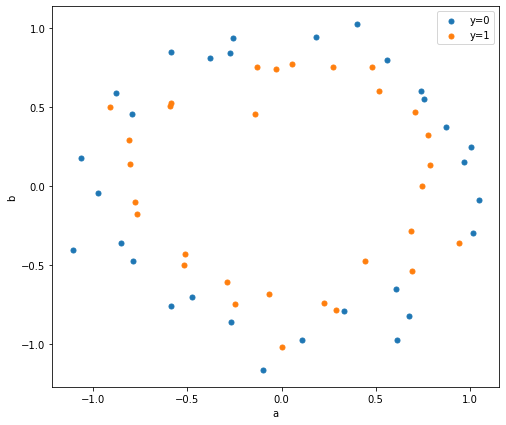

In [ ]:
from sklearn import datasets
X, y = datasets.make_circles(60, noise=0.1, random_state=71)

a0, b0 = X[y==0, 0], X[y==0, 1]
a1, b1 = X[y==1, 0], X[y==1, 1]

plt.figure(figsize=(8, 7))
plt.scatter(a0, b0, marker='o', s=25, label='y=0')
plt.scatter(a1, b1, marker='o', s=25, label='y=1')
plt.legend()
plt.xlabel('a')
plt.ylabel('b')
plt.show()

In [ ]:
training_input = {'A': X[y==0][0:20], 'B': X[y==1][0:20]}
test_input = {'A': X[y==0][20:30], 'B': X[y==1][20:30]}

In [ ]:
# Breast_cancerと同じスケール(-1, 1)でプロットするためにdatasetを規格化
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input)
dataset_array = np.vstack([train_for_pred, test_for_pred])
min_array, max_array = dataset_array.min(), dataset_array.max()
training_input = {k:(v-min_array)/(max_array-min_array)*2-1 for k,v in training_input.items()}
test_input = {k:(v-min_array)/(max_array-min_array)*2-1 for k,v in test_input.items()} 

kernel matrix during the training:


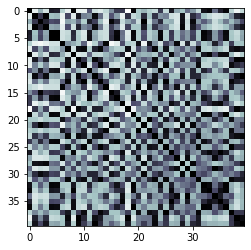

testing success ratio:  0.9


In [ ]:
result = SklearnSVM(training_input, test_input, mesh_list).run()
print("kernel matrix during the training:")
kernel_matrix = result['kernel_matrix_training']
img = plt.imshow(np.asmatrix(kernel_matrix), interpolation='nearest', origin='upper', cmap='bone_r')
plt.show()

print("testing success ratio: ", result['testing_accuracy'])

In [ ]:
# モデル評価
# 誤分類チェックのためにtraining/testデータを予測データとして利用
(train_for_pred, _), _ = split_dataset_to_data_and_labels(training_input)
(test_for_pred, _), _ = split_dataset_to_data_and_labels(test_input)
train_result = SklearnSVM(training_input, test_input, train_for_pred).run()
test_result = SklearnSVM(training_input, test_input, test_for_pred).run()

eval_model(test_result["predicted_classes"])

result:  ['A', 'A', 'B', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'A', 'B', 'B']
truth :  ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']
{'accuracy': 0.9, 'precision': 0.9, 'recall': 0.9, 'specificity': 0.9, 'F1-measure': 0.9}


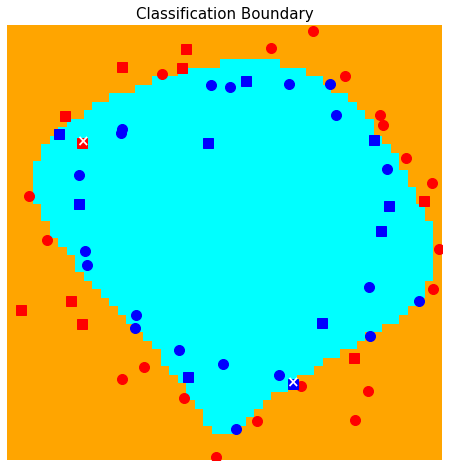

In [ ]:
plt.figure(figsize=(8, 8))               
heatmap(result["predicted_labels"])
scatter_data(train_for_pred, test_for_pred, train_result["predicted_labels"], test_result["predicted_labels"],yshift=-0.014)
plt.show()
# 赤がA、青がBのラベル。●が訓練データで、■がテストデータ

In [ ]:
from qiskit.aqua.components.feature_maps import FeatureMap
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import BlueprintCircuit
import math

class CustomFeatureMap(FeatureMap):
    """Mapping data with a custom feature map."""
    
    def __init__(self, feature_dimension, depth=2, entangler_map=None):
        """
        Args:
            feature_dimension (int): number of features
            depth (int): the number of repeated circuits
            entangler_map (list[list]): describe the connectivity of qubits, each list describes
                                        [source, target], or None for full entanglement.
                                        Note that the order is the list is the order of
                                        applying the two-qubit gate.        
        """
        self._support_parameterized_circuit = False
        self._feature_dimension = feature_dimension
        self._num_qubits = self._feature_dimension = feature_dimension
        self._depth = depth
        self._entangler_map = None
        if self._entangler_map is None:
            self._entangler_map = [[i, j] for i in range(self._feature_dimension) for j in range(i + 1, self._feature_dimension)]
            
    def construct_circuit(self, x, qr, inverse=False):
        """Construct the feature map circuit.
        
        Args:
            x (numpy.ndarray): 1-D to-be-transformed data.
            qr (QauntumRegister): the QuantumRegister object for the circuit.
            inverse (bool): whether or not to invert the circuit.
            
        Returns:
            QuantumCircuit: a quantum circuit transforming data x.
        """
        qc = QuantumCircuit(qr)

        
        for _ in range(self._depth):


            
            qc.h(qr[0])
            qc.h(qr[1])
            
            qc.u1(x[0], qr[0])
            qc.u1(x[1], qr[1])
            
            qc.cx(qr[0], qr[1])
            qc.u1(np.pi * x[0] * x[1], qr[1])
            qc.cx(qr[0], qr[1])
                    
        if inverse:
            qc.inverse()
        return qc

In [ ]:
#Y, Z
%%time
backend = BasicAer.get_backend('qasm_simulator')
feature_map = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map, training_input, test_input)  # the data for prediction can be fed later.
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.9
CPU times: user 18.5 s, sys: 494 ms, total: 19 s
Wall time: 25.3 s


In [ ]:
#X, Y
%%time
backend = BasicAer.get_backend('qasm_simulator')
feature_map = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map, training_input, test_input)  # the data for prediction can be fed later.
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.7
CPU times: user 17.5 s, sys: 496 ms, total: 18 s
Wall time: 23.6 s


In [ ]:
#Z, Z
%%time
backend = BasicAer.get_backend('qasm_simulator')
feature_map = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map, training_input, test_input)  # the data for prediction can be fed later.
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.7
CPU times: user 11.8 s, sys: 473 ms, total: 12.3 s
Wall time: 18.7 s


In [ ]:
feature_map = ZZFeatureMap(feature_dim, reps=2)
svm = QSVM(feature_map, training_input, test_input, None)# the data for prediction can be fed later.
svm.random_seed = random_seed
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=random_seed, seed_transpiler=random_seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

In [ ]:
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  0.75


In [ ]:
#Z, Z np.pi * np.cos(x[0]) * np.cos([x[1]])
%%time
backend = BasicAer.get_backend('qasm_simulator')
feature_map = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map, training_input, test_input)  # the data for prediction can be fed later.
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.65
CPU times: user 11.2 s, sys: 457 ms, total: 11.7 s
Wall time: 17.9 s


In [ ]:
#Z, Z 5 * np.cos(x[0]) * np.cos([x[1]])
%%time
backend = BasicAer.get_backend('qasm_simulator')
feature_map = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map, training_input, test_input)  # the data for prediction can be fed later.
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.7
CPU times: user 11.1 s, sys: 440 ms, total: 11.6 s
Wall time: 17.4 s


In [ ]:
#Z, Z
%%time
backend = BasicAer.get_backend('qasm_simulator')
feature_map = CustomFeatureMap(feature_dimension=2, depth=2)
svm = QSVM(feature_map, training_input, test_input)  # the data for prediction can be fed later.
svm.random_seed = 71
quantum_instance = QuantumInstance(backend, shots=shots, seed_simulator=seed, seed_transpiler=seed)
result = svm.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 
                The <class '__main__.CustomFeatureMap'> object as input for the QSVM is deprecated as of 0.7.0 and will
                be removed no earlier than 3 months after the release.
                You should pass a QuantumCircuit object instead.
                See also qiskit.circuit.library.data_preparation for a collection
                of suitable circuits.
  This is separate from the ipykernel package so we can avoid doing imports until


testing success ratio:  0.5
CPU times: user 11.8 s, sys: 535 ms, total: 12.3 s
Wall time: 18.9 s


In [ ]:
# 時間かけてでもjupyter上で実行したい場合は以下のコードで実行可能
(iter_num, input_size) = (51*3, 17)
mesh_list_iter = np.array(mesh_list).reshape(iter_num, input_size, feature_dim)

mesh_predict_tmp = []
for i, iter_list in enumerate(tqdm(mesh_list_iter)):
    tmp_list = svm.predict(iter_list)
    mesh_predict_tmp.append(tmp_list)
    print("epoch ", i, " has done ",list(tmp_list))

mesh_predict_result = np.array(mesh_predict_tmp).reshape(-1)

epoch  0  has done  [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epoch  1  has done  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
epoch  2  has done  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1]
epoch  3  has done  [1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
epoch  4  has done  [0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0]
epoch  5  has done  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
epoch  6  has done  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1]
epoch  7  has done  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
epoch  8  has done  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
epoch  9  has done  [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]
epoch  10  has done  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
epoch  11  has done  [0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]
epoch  12  has done  [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1]
epoch  13  has done  [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/qiskit/transpiler/passes/optimization/optimize_1q_gates.py:185: RuntimeWarning: invalid value encountered in remainder
  (2 * np.pi)) == 0:


ValueError: ignored

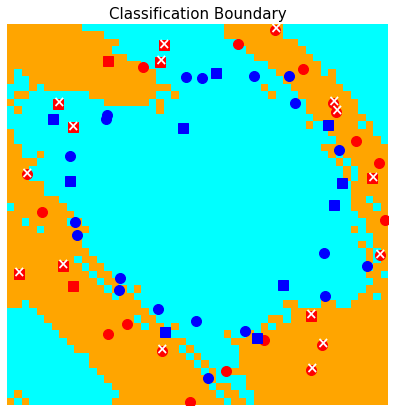

In [ ]:
#Y, Z
mesh_predict_result = np.array(mesh_predict_tmp).reshape(-1)
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.014)
plt.show()

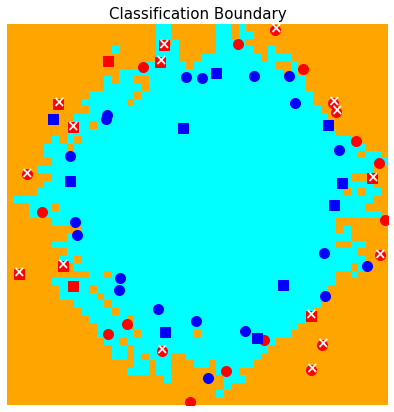

In [ ]:
#X, Y
mesh_predict_result = np.array(mesh_predict_tmp).reshape(-1)
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.014)
plt.show()

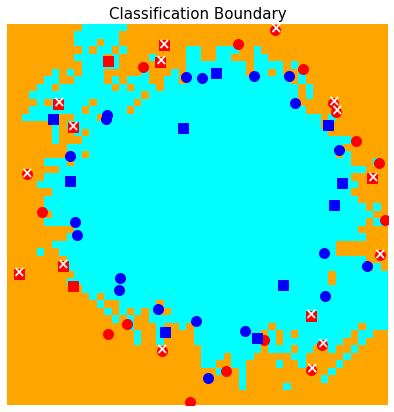

In [ ]:
#Z, Z
mesh_predict_result = np.array(mesh_predict_tmp).reshape(-1)
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.014)
plt.show()

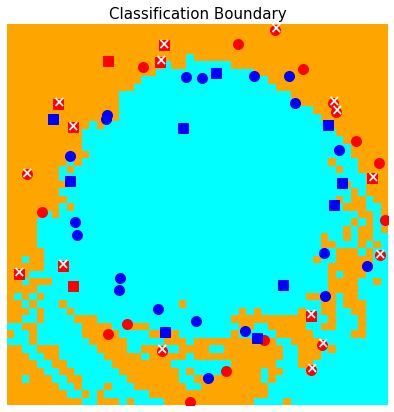

In [ ]:
#Z, Z
mesh_predict_result = np.array(mesh_predict_tmp).reshape(-1)
plt.figure(figsize=(7, 7))               
heatmap(mesh_predict_result)
scatter_data(train_for_pred, test_for_pred, train_result, test_result ,yshift=-0.014)
plt.show()